In [ ]:
!pip install scikit-plot
import scikitplot as skplt
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.models import save_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import datetime
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score
import pandas as pd
import numpy as np
import glob
import os

In [ ]:
# base model is the VGG19 model
base_model = VGG19(weights='imagenet', include_top=False)
x = base_model.output
# conv layer output is fed to global average pooling
# vgg19 layers have been made trainable
# started with imagenet weights
x = GlobalAveragePooling2D()(x)
# average pooling to reduce dimensionality followed by fully connected and classification layer
x = Dense(256, activation='relu')(x)
x = Dropout(0.2)(x)
predictions = Dense(6, activation='softmax')(x)

# model definition
model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.0003), loss='categorical_crossentropy',metrics=['categorical_accuracy'])

print(model.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

In [ ]:
HEIGHT = 224
WIDTH = 224
BATCH_SIZE = 32

# path to main directory
path_to_folders = "papaya dataset"


In [ ]:
files = glob.glob(path_to_folders + "/*/*.jpg")
print("Number of files {}".format(len(files)))

# to split dataset into train and test we'll create a dataframe storing the filepaths and labels
folders = glob.glob(path_to_folders + "\*")
classes = [os.path.basename(x) for x in folders]

# number of files
num_files = len(files)

# dataframe storing all the filepaths and the associated classes
data = pd.DataFrame(files, columns =['filename'])
data['class'] = data['filename'].apply(lambda x: os.path.basename(os.path.dirname(x)))

Number of files 5126


In [ ]:
# split dataset into training and test sets 60:40
xtrain, xtest = train_test_split(data, stratify=data['class'], test_size=0.4, random_state=2021, shuffle=True)

xtrain = xtrain.reset_index(drop=True)
xtest = xtest.reset_index(drop=True)



In [ ]:
# we preprocess and augment the training data using imagedatagenerator
train_datagen = ImageDataGenerator(
        rotation_range=20,
        preprocessing_function = preprocess_input,
        shear_range=0.2,
        validation_split= 0.40,
        horizontal_flip=True,
        fill_mode='nearest')

# only preprocessing for validation set
val_datagen = ImageDataGenerator(preprocessing_function = preprocess_input, validation_split=0.40)

# have further divided the training set into training and validation set 60:40
# will use checkpoint to store the best model using validation loss
train_gen = train_datagen.flow_from_dataframe(xtrain,
                                               target_size=(HEIGHT, WIDTH),
                                               color_mode='rgb',
                                               batch_size=BATCH_SIZE,
                                               class_mode='categorical',
                                               shuffle=True,
                                               seed = 123,
                                               subset = 'training')

val_gen = val_datagen.flow_from_dataframe(xtrain,
                                           target_size=(HEIGHT, WIDTH),
                                           color_mode='rgb',
                                           batch_size=BATCH_SIZE,
                                           class_mode='categorical',
                                           shuffle=False,
                                           seed = 123,
                                           subset = 'validation')
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
callbacks = [
    tf.keras.callbacks.ModelCheckpoint('best_model.h5', save_weights_only=True, save_best_only=True, mode='min'),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.25, patience=5, min_lr=1e-5, min_delta=0.00001, verbose=1,
                          mode='min'),
    tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

]

Found 1845 validated image filenames belonging to 6 classes.
Found 1230 validated image filenames belonging to 6 classes.


In [ ]:
history = model.fit(train_gen, validation_data=val_gen, steps_per_epoch=train_gen.n//BATCH_SIZE, validation_steps=val_gen.n//BATCH_SIZE, epochs=40, callbacks=callbacks)


Epoch 1/40
57/57 [==============================] - 92s 1s/step - loss: 2.2589 - categorical_accuracy: 0.1724 - val_loss: 1.7750 - val_categorical_accuracy: 0.1653
Epoch 2/40
57/57 [==============================] - 63s 1s/step - loss: 1.7730 - categorical_accuracy: 0.1954 - val_loss: 1.7106 - val_categorical_accuracy: 0.2418
Epoch 3/40
57/57 [==============================] - 63s 1s/step - loss: 1.6505 - categorical_accuracy: 0.2926 - val_loss: 1.4326 - val_categorical_accuracy: 0.3882
Epoch 4/40
57/57 [==============================] - 63s 1s/step - loss: 1.3980 - categorical_accuracy: 0.3964 - val_loss: 1.2318 - val_categorical_accuracy: 0.5387
Epoch 5/40
57/57 [==============================] - 63s 1s/step - loss: 1.1976 - categorical_accuracy: 0.5084 - val_loss: 1.0731 - val_categorical_accuracy: 0.5271
Epoch 6/40
57/57 [==============================] - 63s 1s/step - loss: 1.0016 - categorical_accuracy: 0.6097 - val_loss: 0.8921 - val_categorical_accuracy: 0.6373
Epoch 7/40
57/57

In [ ]:
history.history.keys()

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])

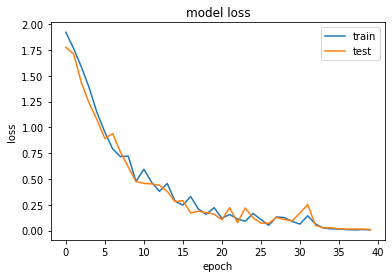

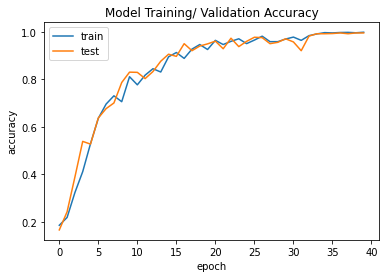

In [ ]:
    # Plot - loss during training
    plt.figure()
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='best')
    plt.show()

    plt.figure()
    plt.plot(history.history['categorical_accuracy'])
    plt.plot(history.history['val_categorical_accuracy'])
    plt.title('Model Training/ Validation Accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='best')
    plt.show()

In [ ]:
model.load_weights("best_model.h5")

In [ ]:
test_gen = val_datagen.flow_from_dataframe(xtest,
                                           target_size=(HEIGHT, WIDTH),
                                           color_mode='rgb',
                                           batch_size=BATCH_SIZE,
                                           class_mode='categorical',
                                           shuffle=False,
                                           )

pred_proba = model.predict(test_gen)

Found 2051 validated image filenames belonging to 6 classes.


In [ ]:
pred = np.argmax(pred_proba, axis=1)

print(pred.shape)

(2051,)


In [ ]:
misclassified = list(np.where(test_gen.labels != pred)[0])
classified = list(np.where(test_gen.labels == pred)[0])

if len(misclassified) > 2:
  plot_images = misclassified[3:5] + classified[10:14]
elif len(misclassified) == 2:
  plot_images = misclassified[0:2] + classified[10:14]
elif 1 >= len(misclassified) < 2:
  plot_images = misclassified[0] + classified[10:15]
else:
  plot_images = classified[10:16]

Time taken by VGG for prediction (1 image) 0.08176207542419434 seconds


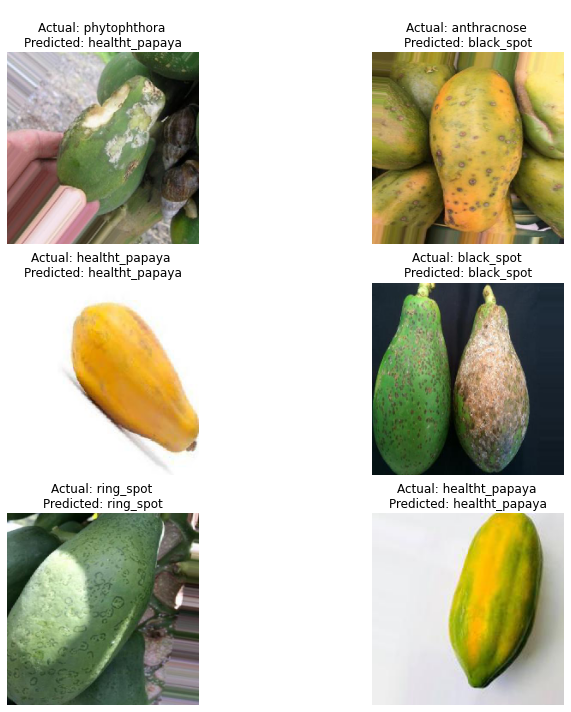

In [ ]:
import matplotlib.gridspec as gridspec
import time
labels = [k for k in test_gen.class_indices.keys()]
fig = plt.figure(figsize=(12,12))
cols = 2
rows = 3
grid = gridspec.GridSpec(nrows=rows, ncols=cols, figure=fig)

for c, i in enumerate(plot_images):
    fig.add_subplot(grid[c])
    img = load_img(xtest['filename'].iloc[i], target_size=(HEIGHT, WIDTH))
    plt.axis(False)
    plt.imshow(img)
    img_arr = img_to_array(img)
    img_arr = preprocess_input(img_arr)
    input_arr = np.array([img_arr])
    st = time.time()
    pred_subset = model.predict(input_arr)
    end = time.time()
    plt.title("\nActual: {} \nPredicted: {}".format(xtest['class'].iloc[i], labels[np.argmax(pred_subset)]))
    # print("Actual: {}".format(xtest['class'].iloc[i]))
    # print("Predicted: {}".format())
    
print("Time taken by VGG for prediction (1 image) {} seconds".format(end - st))

In [ ]:
img = load_img("path_to_image", target_size=(HEIGHT, WIDTH))
plt.axis(False)
plt.imshow(img)
img_arr = img_to_array(img)
img_arr = preprocess_input(img_arr)
input_arr = np.array([img_arr])
st = time.time()
pred_subset = model.predict(input_arr)
end = time.time()
plt.title("\nActual: {} \nPredicted: {}".format(xtest['class'].iloc[i], labels[np.argmax(pred_subset)]))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


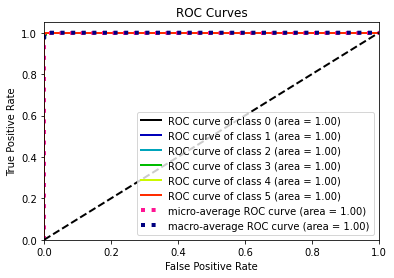

In [ ]:
skplt.metrics.plot_roc_curve(test_gen.labels, pred_proba)
plt.show()

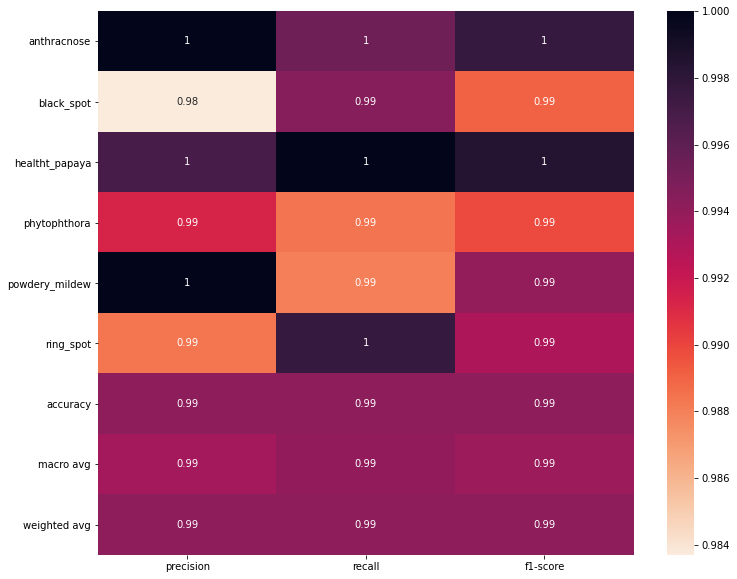

In [ ]:
from sklearn.metrics import classification_report

clf_report = classification_report(test_gen.labels,
                                   pred,
                                   labels=[k for k in test_gen.class_indices.values()],
                                   target_names=[k for k in test_gen.class_indices.keys()],
                                   output_dict=True)
plt.figure(figsize = (12,10))
sn.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True, cmap="rocket_r")

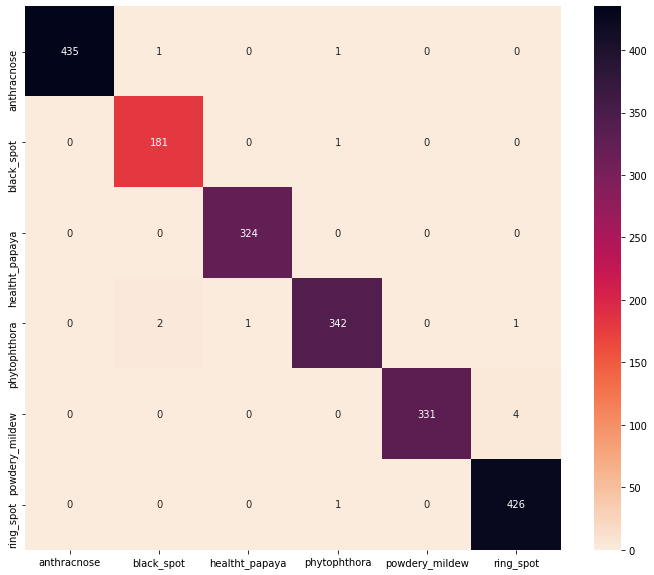

In [ ]:
def plot_confusion_matrix(y_true, y_pred, labels, colormap = None):
    cn = confusion_matrix(y_true, y_pred)
    df = pd.DataFrame(cn, index=labels, columns=labels)
    plt.figure(figsize = (12,10))
    sn.heatmap(df, annot=True, fmt='g', cmap=colormap)
    plt.show()

plot_confusion_matrix(test_gen.labels, pred, [k for k in test_gen.class_indices.keys()], "rocket_r")

In [ ]:
acc = accuracy_score(test_gen.labels, pred)
print("VGG Accuracy score (test set): {:.2%}".format(acc))

VGG Accuracy score (test set): 99.41%


In [ ]:
# Layers definitions for the current model to locate the global average pooling layer
from tensorflow.keras import backend as K
for l in range(len(model.layers)):
    print(l, model.layers[l])

0 <tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f37bfd779d0>
1 <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f37bfd4cd50>
2 <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f37bf548510>
3 <tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f37bf5285d0>
4 <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f37b04e3390>
5 <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f37bf527390>
6 <tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f37bf5277d0>
7 <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f37b04f0cd0>
8 <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f37b04fad90>
9 <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f37b04edcd0>
10 <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f37b0502a90>
11 <tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f37b050bb50>
12 <tensorflow.python.ke

In [ ]:
# extract features from the global average pooling layer
getFeature = K.function([model.layers[0].input],
                        [model.layers[22].output])

num_train = train_gen.n
num_test = test_gen.n

In [ ]:
# using the function above get feature maps for generators
# each batch of training set - obtained using train generator is fed as an input to the frozen VGG19 layers
# And output from global average pool layer is stored as the feature map for each batch
# this is the feature set which is used for training the SVC
# label value obtained from the generator remains the same
def extract_features(generator, sample_count):
  # output of average pooling has 512 features
  features = np.zeros(shape=(sample_count, 512))  
  labels = np.zeros(shape=(sample_count, 6))

  # Pass data through convolutional base
  last_index = 0
  for inputs_batch, labels_batch in generator:
      # Using tensorflow backend extract features from the global average pool layer in VGG19
      features_batch = getFeature(inputs_batch)
      # Generators using data sugmentation can give infinite data
      # using the if condition we limit our data rows to be equal to the sample_count input
      if last_index +  features_batch[0].shape[0] < sample_count:
        features[last_index: (last_index + features_batch[0].shape[0])] = features_batch[0]
        labels[last_index: (last_index + features_batch[0].shape[0])] = labels_batch
        last_index += features_batch[0].shape[0]
      # once we reach the sample_count value or exceed it we break from the loop
      else:
        break

  return features, labels


train_features, train_labels = extract_features(train_gen, num_train)

In [ ]:
# convert lists into
train_features = np.array(train_features)
train_labels = np.array(train_labels)

In [ ]:
print(train_features.shape)
print(num_train)

(1845, 512)
1845


In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
import time

# hyperparameter tuning
parameters = {'kernel':['linear', 'rbf', 'poly'], 
              'C':[0.1, 10, 100],
              'gamma':[1e-3, 1e-4, 'auto']}
# probability = True for plotting roc curve - much slower than probability = False
start_time = time.time()
clf = GridSearchCV(SVC(probability=True, random_state=2021), parameters, n_jobs=-1, verbose=5, cv=10)
clf.fit(train_features.reshape(num_train,512), np.argmax(train_labels, axis=1))
end_time = time.time()

print("Time taken for hyperparameter tuning {} seconds".format(end_time - start_time))

Fitting 10 folds for each of 27 candidates, totalling 270 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 270 out of 270 | elapsed:  4.0min finished


Time taken for hyperparameter tuning 241.40563821792603 seconds


In [ ]:
# best model is retrained on training dataset by gridsearchcv
clf.best_estimator_

SVC(C=100, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.0001, kernel='rbf',
    max_iter=-1, probability=True, random_state=2021, shrinking=True, tol=0.001,
    verbose=False)

In [ ]:
# extract features for the test set (no augmentation)
test_features, test_labels = extract_features(test_gen, test_gen.n)

In [ ]:
test_features = np.array(test_features)
test_labels = np.array(test_labels)

In [ ]:
pred = clf.best_estimator_.predict(test_features)
pred_proba =  clf.best_estimator_.predict_proba(test_features)

In [ ]:
misclassified = list(np.where(test_gen.labels != pred)[0])
classified = list(np.where(test_gen.labels == pred)[0])

if len(misclassified) > 2:
  plot_images = misclassified[4:6] + classified[7:11]
elif len(misclassified) == 2:
  plot_images = misclassified[0:2] + classified[7:11]
elif 1 >= len(misclassified) < 2:
  plot_images = misclassified[0] + classified[7:12]
else:
  plot_images = classified[7:13]


Time taken by SVC-VGG for prediction (1 image) 0.0002808570861816406 seconds


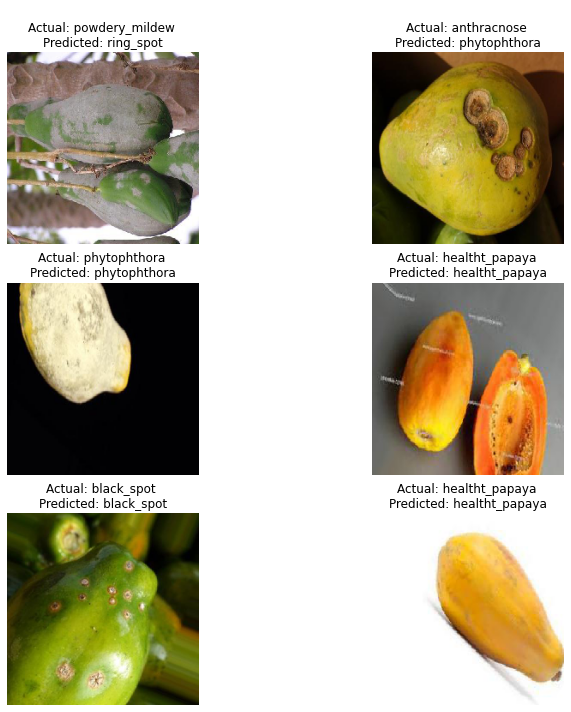

In [ ]:
labels = [k for k in test_gen.class_indices.keys()]
fig = plt.figure(figsize=(12,12))
cols = 2
rows = 3
grid = gridspec.GridSpec(nrows=rows, ncols=cols, figure=fig)


for c, i in enumerate(plot_images):
    fig.add_subplot(grid[c])
    img = load_img(xtest['filename'].iloc[i], target_size=(HEIGHT, WIDTH))
    plt.axis(False)
    plt.imshow(img)
    img_arr = img_to_array(img)
    img_arr = preprocess_input(img_arr)
    input_arr = np.array([img_arr])
    feat = getFeature(input_arr)
    st = time.time()
    pred_subset = clf.best_estimator_.predict(feat[0].reshape(-1, 512))
    end = time.time()
    plt.title("\nActual: {} \nPredicted: {}".format(xtest['class'].iloc[i], labels[pred_subset[0]]))
    # print("Actual: {}".format(xtest['class'].iloc[i]))
    # print("Predicted: {}".format(labels[pred_subset[0]]))
  
print("Time taken by SVC-VGG for prediction (1 image) {} seconds".format(end - st))


In [ ]:
img = load_img("path_to_file", target_size=(HEIGHT, WIDTH))
plt.axis(False)
plt.imshow(img)
img_arr = img_to_array(img)
img_arr = preprocess_input(img_arr)
input_arr = np.array([img_arr])
feat = getFeature(input_arr)
st = time.time()
pred_subset = clf.best_estimator_.predict(feat[0].reshape(-1, 512))
end = time.time()
plt.title("\nActual: {} \nPredicted: {}".format(xtest['class'].iloc[i], labels[pred_subset[0]])

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


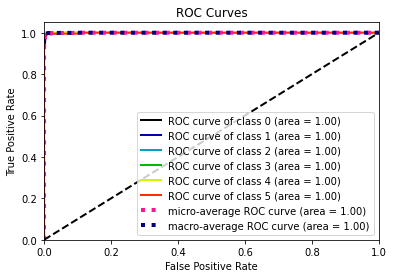

In [ ]:
skplt.metrics.plot_roc_curve(test_gen.labels, pred_proba)
plt.show()

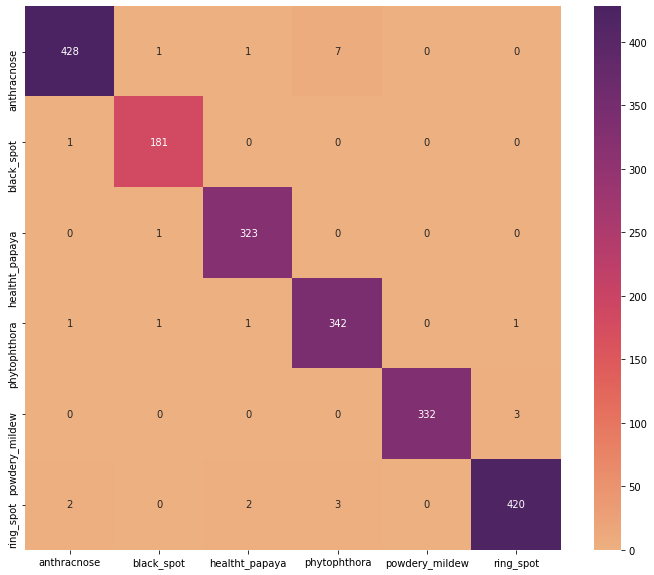

In [ ]:
plot_confusion_matrix(test_gen.labels, pred, [k for k in test_gen.class_indices.keys()], colormap="flare")

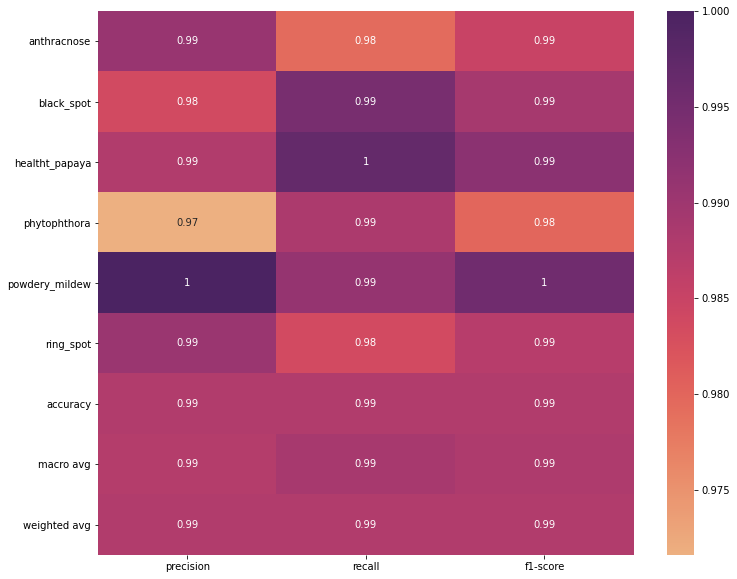

In [ ]:
clf_report = classification_report(test_gen.labels,
                                   pred,
                                   labels=[k for k in test_gen.class_indices.values()],
                                   target_names=[k for k in test_gen.class_indices.keys()],
                                   output_dict=True)
plt.figure(figsize = (12,10))
sn.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True, cmap="flare")

In [ ]:
acc = accuracy_score(test_gen.labels, pred)
print("SVM-VGG Accuracy score (test set): {:.2%}".format(acc))

SVM-VGG Accuracy score (test set): 98.78%


In [ ]:
from sklearn.neighbors import KNeighborsClassifier


# hyperparameter tuning
parameters = {'n_neighbors':[5, 10, 15], 
              'weights':['uniform', 'distance'],
              }
# probability = True for plotting roc curve - much slower than probability = False
start_time = time.time()
clf = GridSearchCV(KNeighborsClassifier(), parameters, n_jobs=-1, verbose=5, cv=10)
clf.fit(train_features.reshape(num_train,512), np.argmax(train_labels, axis=1))
end_time = time.time()

print("Time taken for hyperparameter tuning {} seconds".format(end_time - start_time))

Fitting 10 folds for each of 6 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    1.3s


Time taken for hyperparameter tuning 5.879714488983154 seconds


[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    5.7s finished


In [ ]:
# best model is retrained on training dataset by gridsearchcv
clf.best_estimator_

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [ ]:
pred = clf.best_estimator_.predict(test_features)
pred_proba =  clf.best_estimator_.predict_proba(test_features)

In [ ]:
misclassified = list(np.where(test_gen.labels != pred)[0])
classified = list(np.where(test_gen.labels == pred)[0])

if len(misclassified) > 2:
  plot_images = misclassified[2:4] + classified[13:17]
elif len(misclassified) == 2:
  plot_images = misclassified[0:2] + classified[13:17]
elif 1 >= len(misclassified) < 2:
  plot_images = misclassified[0] + classified[13:18]
else:
  plot_images = classified[13:19]

Time taken by KNN-VGG for prediction (1 image) 0.001161813735961914 seconds


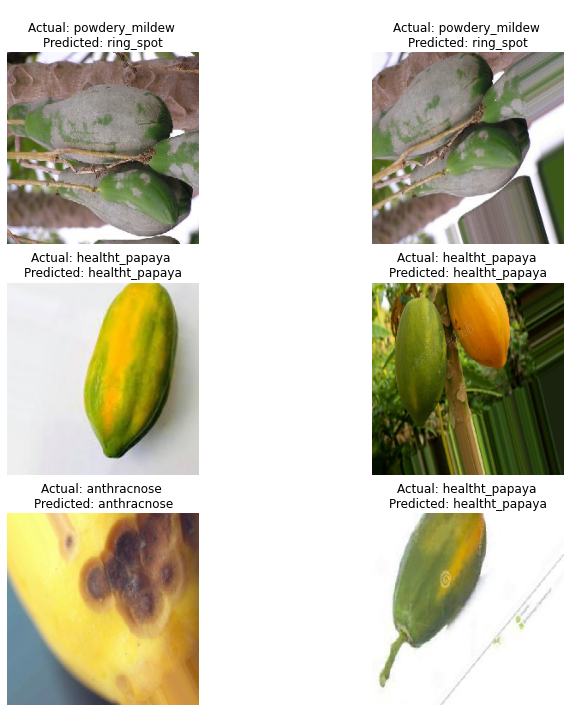

In [ ]:
labels = [k for k in test_gen.class_indices.keys()]
fig = plt.figure(figsize=(12,12))
cols = 2
rows = 3
grid = gridspec.GridSpec(nrows=rows, ncols=cols, figure=fig)


for c, i in enumerate(plot_images):
    fig.add_subplot(grid[c])
    img = load_img(xtest['filename'].iloc[i], target_size=(HEIGHT, WIDTH))
    plt.axis(False)
    plt.imshow(img)
    img_arr = img_to_array(img)
    img_arr = preprocess_input(img_arr)
    input_arr = np.array([img_arr])
    feat = getFeature(input_arr)
    st = time.time()
    pred_subset = clf.best_estimator_.predict(feat[0].reshape(-1, 512))
    end = time.time()
    plt.title("\nActual: {} \nPredicted: {}".format(xtest['class'].iloc[i], labels[pred_subset[0]]))
    # print("Actual: {}".format(xtest['class'].iloc[i]))
    # print("Predicted: {}".format(labels[pred_subset[0]]))
  
print("Time taken by KNN-VGG for prediction (1 image) {} seconds".format(end - st))


In [ ]:
img = load_img("path_to_file", target_size=(HEIGHT, WIDTH))
plt.axis(False)
plt.imshow(img)
img_arr = img_to_array(img)
img_arr = preprocess_input(img_arr)
input_arr = np.array([img_arr])
feat = getFeature(input_arr)
st = time.time()
pred_subset = clf.best_estimator_.predict(feat[0].reshape(-1, 512))
end = time.time()
plt.title("\nActual: {} \nPredicted: {}".format(xtest['class'].iloc[i], labels[pred_subset[0]])

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


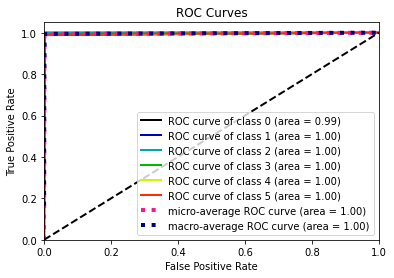

In [ ]:
skplt.metrics.plot_roc_curve(test_gen.labels, pred_proba)
plt.show()

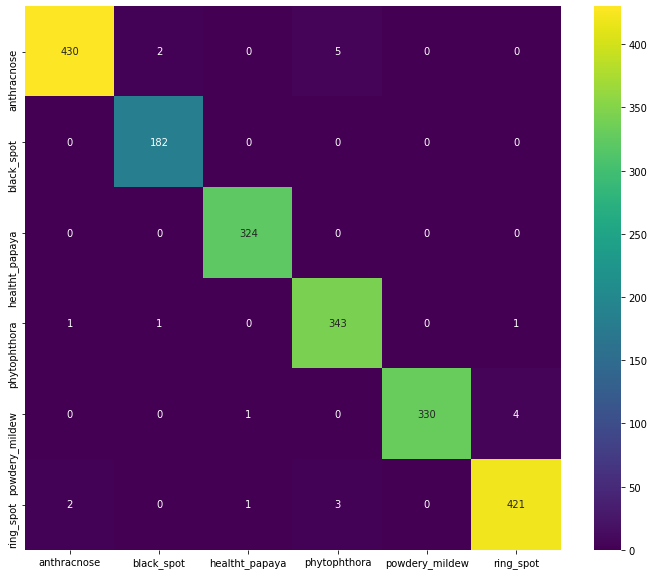

In [ ]:
plot_confusion_matrix(test_gen.labels, pred, [k for k in test_gen.class_indices.keys()], colormap="viridis")

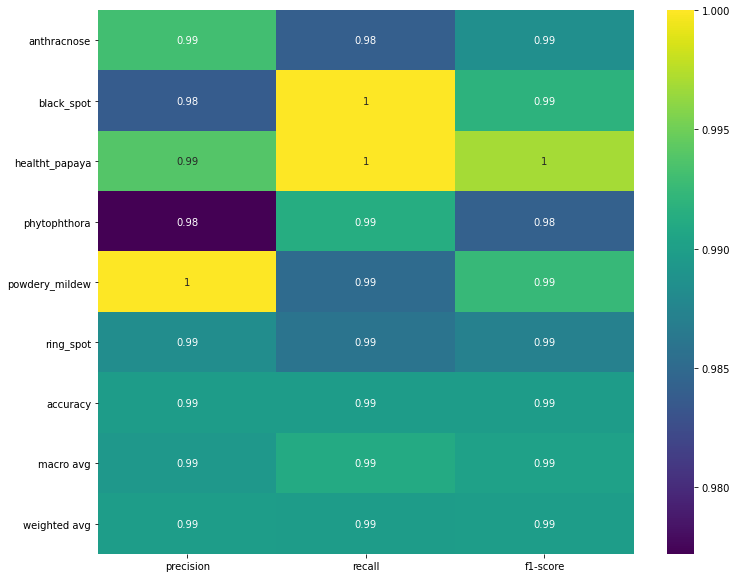

In [ ]:
clf_report = classification_report(test_gen.labels,
                                   pred,
                                   labels=[k for k in test_gen.class_indices.values()],
                                   target_names=[k for k in test_gen.class_indices.keys()],
                                   output_dict=True)
plt.figure(figsize = (12,10))
sn.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True, cmap="viridis")

In [ ]:
acc = accuracy_score(test_gen.labels, pred)
print("KNN-VGG Accuracy score (test set): {:.2%}".format(acc))

KNN-VGG Accuracy score (test set): 98.98%


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import time

# hyperparameter tuning
parameters = {'n_estimators':[200, 400], 
              'max_depth':[5,8],
              'min_samples_leaf':[3, 5],
              'max_features':['sqrt', 'auto']
              
              }
# probability = True for plotting roc curve - much slower than probability = False
start_time = time.time()
clf = GridSearchCV(RandomForestClassifier(random_state=2021), parameters, n_jobs=-1, verbose=5, cv=10)
clf.fit(train_features.reshape(num_train,512), np.argmax(train_labels, axis=1))
end_time = time.time()

print("Time taken for hyperparameter tuning {} seconds".format(end_time - start_time))

Fitting 10 folds for each of 16 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   13.7s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:  3.1min finished


Time taken for hyperparameter tuning 187.44462871551514 seconds


In [ ]:
# best model is retrained on training dataset by gridsearchcv
clf.best_estimator_

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=2021,
                       verbose=0, warm_start=False)

In [ ]:
pred = clf.best_estimator_.predict(test_features)
pred_proba =  clf.best_estimator_.predict_proba(test_features)

In [ ]:
misclassified = list(np.where(test_gen.labels != pred)[0])
classified = list(np.where(test_gen.labels == pred)[0])

if len(misclassified) > 2:
  plot_images = misclassified[1:3] + classified[3:7]
elif len(misclassified) == 2:
  plot_images = misclassified[0:2] + classified[3:7]
elif 1 >= len(misclassified) < 2:
  plot_images = misclassified[0] + classified[3:8]
else:
  plot_images = classified[3:9]

Time taken by RF-VGG for prediction (1 image) 0.020673036575317383 seconds


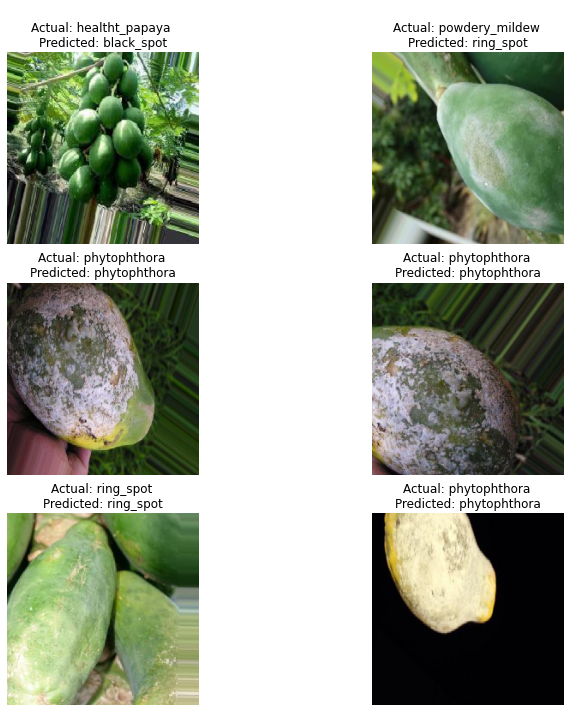

In [ ]:
labels = [k for k in test_gen.class_indices.keys()]
fig = plt.figure(figsize=(12,12))
cols = 2
rows = 3
grid = gridspec.GridSpec(nrows=rows, ncols=cols, figure=fig)


for c, i in enumerate(plot_images):
    fig.add_subplot(grid[c])
    img = load_img(xtest['filename'].iloc[i], target_size=(HEIGHT, WIDTH))
    plt.axis(False)
    plt.imshow(img)
    img_arr = img_to_array(img)
    img_arr = preprocess_input(img_arr)
    input_arr = np.array([img_arr])
    feat = getFeature(input_arr)
    st = time.time()
    pred_subset = clf.best_estimator_.predict(feat[0].reshape(-1, 512))
    end = time.time()
    plt.title("\nActual: {} \nPredicted: {}".format(xtest['class'].iloc[i], labels[pred_subset[0]]))
    # print("Actual: {}".format(xtest['class'].iloc[i]))
    # print("Predicted: {}".format(labels[pred_subset[0]]))
  
print("Time taken by RF-VGG for prediction (1 image) {} seconds".format(end - st))


In [ ]:
img = load_img("path_to_file", target_size=(HEIGHT, WIDTH))
plt.axis(False)
plt.imshow(img)
img_arr = img_to_array(img)
img_arr = preprocess_input(img_arr)
input_arr = np.array([img_arr])
feat = getFeature(input_arr)
st = time.time()
pred_subset = clf.best_estimator_.predict(feat[0].reshape(-1, 512))
end = time.time()
plt.title("\nActual: {} \nPredicted: {}".format(xtest['class'].iloc[i], labels[pred_subset[0]])

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


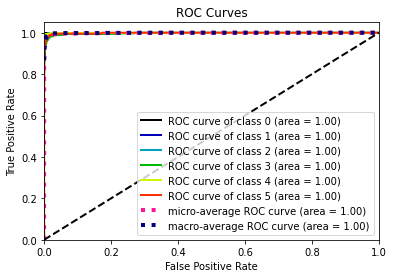

In [ ]:
skplt.metrics.plot_roc_curve(test_gen.labels, pred_proba)
plt.show()

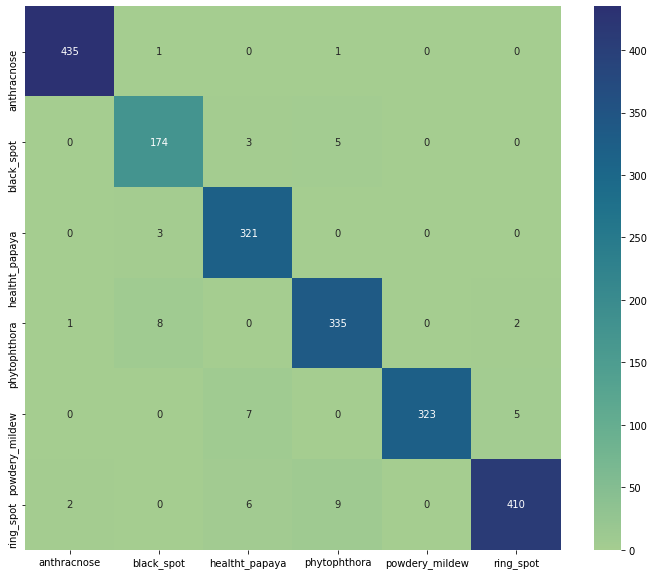

In [ ]:
plot_confusion_matrix(test_gen.labels, pred, [k for k in test_gen.class_indices.keys()], colormap="crest")

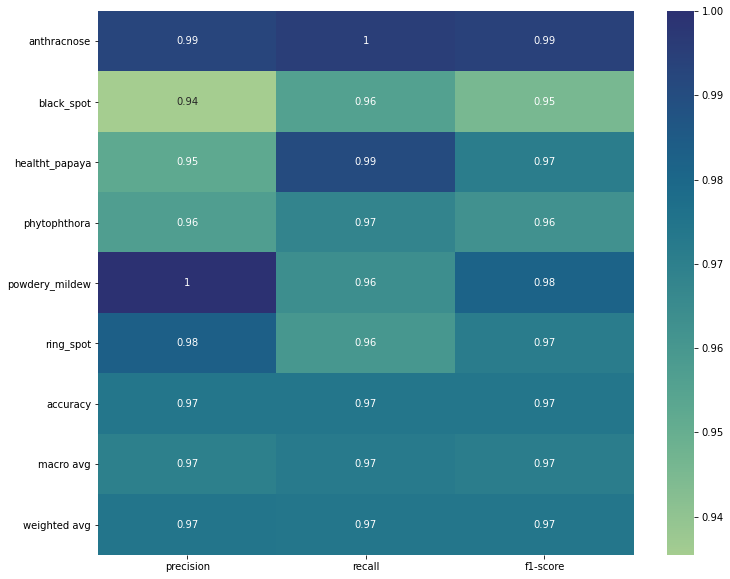

In [ ]:
clf_report = classification_report(test_gen.labels,
                                   pred,
                                   labels=[k for k in test_gen.class_indices.values()],
                                   target_names=[k for k in test_gen.class_indices.keys()],
                                   output_dict=True)
plt.figure(figsize = (12,10))
sn.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True, cmap="crest")

In [ ]:
acc = accuracy_score(test_gen.labels, pred)
print("RF-VGG Accuracy score (test set): {:.2%}".format(acc))

RF-VGG Accuracy score (test set): 97.42%
